In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from matplotlib.colors import LinearSegmentedColormap
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler


In [54]:
import eli5
from eli5.sklearn import PermutationImportance

In [55]:
data = pd.read_csv("../data/customer_data.csv").set_index('customerID')
df = data.copy()

# data preparation for training

In [56]:
def datapreparation(df=df):
    
    df.TotalCharges = df.TotalCharges.replace(" ",np.nan)
    df.TotalCharges.fillna(0, inplace = True)
    df.TotalCharges = df.TotalCharges.astype(float)
    
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)
    
    return df

df = datapreparation()

/tmp/ipykernel_45567/1833045729.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.TotalCharges.fillna(0, inplace = True)


In [57]:
from sklearn.preprocessing import MinMaxScaler

### Splitting data
- We've seen that the dataset has imbalanced classes thus we need to keep the same initial distribution in the training and testing dataset. Solution: set the *stratify* parameter to the target column.
Sans stratify : Le hasard pourrait mettre tous tes "Churners" dans le groupe d'entraînement. Ton modèle de test ne verrait alors que des gens qui restent, et tu ne saurais jamais si ton modèle est capable de détecter un départ.<br>

Avec stratify : Tu simules la réalité de manière équitable dans les deux sous-groupes.
- Random state: since the random state must be a fixed just so that the train and test sets will be the same every time we try to split the data. I will set it to a random but **fixed** integer. 
- The test would be 30% of the dataset and the training set would be 70% of the dataset.

In [58]:
def split_data():
    columns = df.columns
    X = df.drop(columns=["Churn"]) # every column except the target: churn
    Y = df["Churn"]
    return  train_test_split(X,Y, test_size=0.3, random_state=100, stratify = Y)



### Training the knn model
- The weights are uniform because from the exploration, we found that there are some columns inversely related to churning but so important nevertheless.
- the metric is haming because ewe are dealing with categorical and boolean data mostly
- the data columns distributions is not normally shaped so we will use the MinMaxScaler
- Data normalization is specefied in the model by balancing the classes weight

In [59]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

In [60]:
def grid_searchCV(pipeline, x_train, y_train):
    param_grid = {
    'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 75], 
    'knn__weights': ['uniform', 'distance'],                    
    'knn__metric': ['euclidean', 'manhattan','hamming']                   
    }
    
    grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=param_grid, 
                           cv=5, 
                           verbose=1, 
                           n_jobs=-1)
    grid_search.fit(x_train, y_train)
    
    return grid_search.best_estimator_

In [61]:

x_train, x_test, y_train, y_test = split_data()
model = grid_searchCV(pipeline, x_train, y_train) 
    

Fitting 5 folds for each of 72 candidates, totalling 360 fits


### Features' weights:

In [62]:
perm = PermutationImportance(model, random_state=1).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
0.0157 ± 0.0067,Contract_One year
0.0136 ± 0.0128,InternetService_Fiber optic
0.0111 ± 0.0094,OnlineBackup
0.0098 ± 0.0074,InternetService_No
0.0082 ± 0.0052,tenure
0.0081 ± 0.0050,DeviceProtection
0.0047 ± 0.0063,gender
0.0044 ± 0.0073,Contract_Two year
0.0033 ± 0.0072,MonthlyCharges
0.0030 ± 0.0022,TotalCharges


In [63]:
y_predict = model.predict(x_test)
print(f"accuracy score is:{accuracy_score(y_test, y_test)}")

accuracy score is:1.0


Text(0.5, 1.0, 'Confusion matrix')

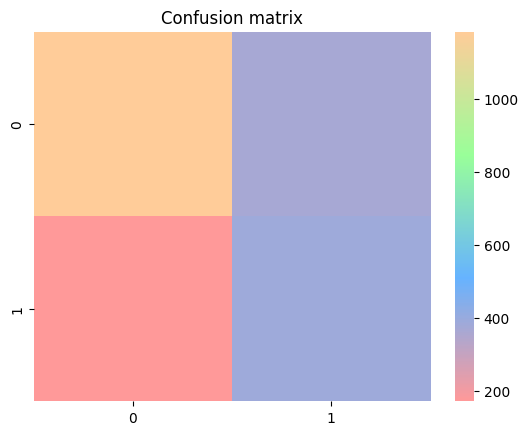

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.Figure(figsize=(2,2))
cm = confusion_matrix(y_test, y_predict)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
my_cmap = LinearSegmentedColormap.from_list("custom_pals", colors, N=256)
sns.heatmap(cm, cmap = my_cmap)
plt.title("Confusion matrix")

In [65]:
report_dictionary = classification_report(y_test, y_predict, output_dict=True)
pd.DataFrame(report_dictionary).transpose()

,precision,recall,f1-score,support
0,0.873156,0.762887,0.814305,1552.000000
1,0.513871,0.693405,0.590288,561.000000
accuracy,0.744439,0.744439,0.744439,0.744439
macro avg,0.693513,0.728146,0.702297,2113.000000
weighted avg,0.777766,0.744439,0.754829,2113.000000


#### Reminder:
class 0: No churn<br>
class 1: Churn
### Explanation: 
The model is doing good when the case is "NO" churning; 85% precision and 86% recall
But when there client is churning, the precision goes down to 60% and the recall to 56%

---
<br>
So overall knn does not suit this problem the best. We need to try and find a better model.

# Naive bais training

- On a utiliser le GaussianNB scaler car naive bais suppose que les donnees sont normales
- le balancer SMOTE est choisi car il equilibre les probabilites a priori des classes, ainsi il permet au model d'apprendre aussi les trends chez les classes minoritaires meme si il cree des exemple synthetique pour ces classes

In [69]:
pipeline_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('nb', GaussianNB())
])

- var_smoothing est le seul parameter a tuner

In [70]:
def grid_search_nb(pipeline, x_train, y_train):
    param_grid = {
        'nb__var_smoothing': np.logspace(0, -9, num=100)
    }
    
    grid_search = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid, 
                               cv=5, 
                               verbose=1, 
                               n_jobs=-1)
    grid_search.fit(x_train, y_train)
    
    return grid_search.best_estimator_


In [71]:
model_nb = grid_search_nb(pipeline_nb, x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


# Prediction et evaluation du model

In [72]:
y_predict_nb = model_nb.predict(x_test)

### Rapport du model

In [73]:
report_nb = classification_report(y_test, y_predict_nb, output_dict=True)
df_report_nb = pd.DataFrame(report_nb).transpose()
display(df_report_nb)

,precision,recall,f1-score,support
0,0.903783,0.708119,0.794075,1552.000000
1,0.494983,0.791444,0.609053,561.000000
accuracy,0.730241,0.730241,0.730241,0.730241
macro avg,0.699383,0.749781,0.701564,2113.000000
weighted avg,0.795247,0.730241,0.744952,2113.000000


### Matrice de confusion

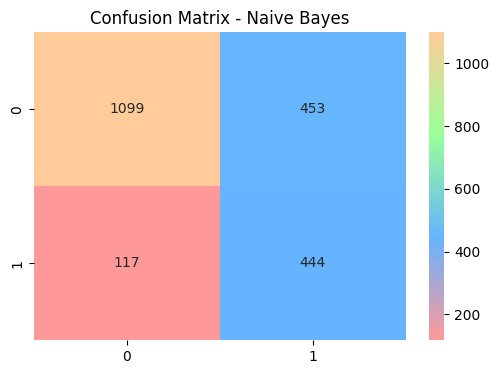

In [74]:
plt.figure(figsize=(6,4))
cm_nb = confusion_matrix(y_test, y_predict_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap=my_cmap)
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

# Explication des resultats:
- Le rappel (recall) du Churn grimpe à 79% (contre 56% avec KNN), donc on rate beaucoup moins de clients qui partent. En revanche, on a plus de fausses alertes car la précision chute à 49%.
- En revnache le model est devenue pessimiste, la precision a chute jusqu'a 49%.


**Bilan:**  Ce modèle est plus utile car il privilégie la détection des départs, même s'il est moins "prudent" que le KNN.